# Wissenschaftliches Rechnen mit SciPy

Das Python-Modul **SciPy** ist eine Sammlung mathematischer Algorithmen, welche überwiegend im wissenschaftlichen Rechnen Anwendung finden. Das Modul ist in verschiedene Untermodule unterteilt. Die wichtigsten sind:

* `scipy.fftpack`: Schnelle Fourier-Transformation
* `scipy.integrate`: Algorithmen zur numerischen Integration und Löser für Differentialgleichungen
* `scipy.interpolate`: Polynom- und Splineinterpolation
* `scipy.linalg`: Lineare Agebra, Rechnen mit Matrizen und Vektoren
* `scipy.optimize`: Algorithmen zur Lösung von beschränkten und unbeschränkten Optimierungsproblemen
* `scipy.signal`: Signalverarbeitung
* `scipy.sparse`: Speicherformate für dünn-besetzte Matrizen
* `scipy.stats`: Wahrscheinlichkeitsverteilungen und statistische Berechnungen

Gegebenenfalls müssen wir **SciPy** zunächst installieren, beispielsweise mit

```bash
conda install -c conda-forge scipy
```

Im Folgenden wollen wir uns einige dieser Pakete genauer anschauen.

## Numerische Integration mit scipy.integrate

### Numerische Integration

Wir haben im Abschnitt {ref}`sympy` bereits eine Methode kennengelernt um Intgrale zu berechnen. Dort wurden allerdings symbolische Berechnungen durchgeführt, das heißt, es wurde versucht ein Integral exakt auszurechnen. Bei zu schwierigen Integralen kam SymPy allerdings auch an seine Grenzen. Wir stellen daher hier einen anderen Ansatz vor, die numerische Integration. 

Zunächst klären wir kurz, wie numerische Integration überhaupt funktioniert. Die Idee ist, die Funktion beispielsweise durch eine Treppenfunktion oder durch ihre stückweise lineare Interpolierende zu ersetzen:

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def f(x):
    return np.exp(x)-x
xmin = -2
xmax = 2
x_coarse = np.linspace(xmin, xmax, 8)
x_fine = np.linspace(xmin,xmax,1000)

plt.figure(figsize=(14,4))

plt.subplot(1,2,1)
plt.plot(x_fine, f(x_fine), linewidth=3)
x_tmp = (np.kron(x_coarse, np.array([1.,1.])))[1:-1]
f_tmp = np.kron(0.5*(f(x_coarse[:-1]) + f(x_coarse[1:])), np.array([1.,1.]))
plt.plot(x_tmp, f_tmp, 'r-o', linewidth = 1)
plt.fill_between(x_tmp,f_tmp, alpha=0.5, color='red')
plt.title("Rechtecksregel")

plt.subplot(1,2,2)
plt.plot(x_fine, f(x_fine), linewidth=3)
plt.plot(x_coarse, f(x_coarse), 'r-o', linewidth = 1)
plt.fill_between(x_coarse, f(x_coarse), alpha=0.5, color='red')
plt.title("Trapezregel")

plt.show()

Für derartige Funktionen kann die Fläche, welche der Funktionsgraph mit der $x$-Achse einschließt exakt und einfach berechnet werden. Bei der zusammengesetzten Rechtecksregel beispielsweise, wird zunächst das Integrationsgebiet in äquidistante Intervalle $I_k = [x_{k-1}, x_{k}]$, $k=1,\ldots,N$, mit Länge $\Delta x = x_{k}-x_{k-1}$ unterteilt. Die Treppenfunktion interpoliert die Funktion dabei im Mittelwert $\frac12(x_{k-1}+x_{k})$ des Intervalls $I_k$. Aus diesen Vorüberlegungen ergibt sich die entspechende **Quadraturformel**

$$
Q^0(f) = \sum_{k=1}^N f\left(\frac12(x_{k-1} + x_k)\right)\,\Delta x.
$$

Analog kann man auch eine Quadraturformel für die zusammengesetzte Trapezregel herleiten:

$$
Q^1(f) = \sum_{k=1}^N \frac12\left(f(x_{k-1})+f(x_k)\right)\,\Delta x.
$$

### Bestimmte Integrale berechnen

Quadraturformeln, wie oben beschrieben, sind im Submodul `scipy.integrate` implementiert. Wir inkludieren dieses Submodul und schauen uns den Hilfetext der wichtigsten Funktion `quad` (quadrature) an:

In [2]:
import scipy.integrate as si

```
si.quad?
```

Als Funktionsparameter benötigt `scipy.integrate.quad` einen Zeiger auf die zu integrierende Funktion sowie die Integrationsgrenzen. Der Rückgabewert ist ein Tupel, welches den Wert des Integrals an erster Stelle und den geschätzten Integrationsfehler an zweiter Stelle beinhaltet. Ein einfaches Beispiel liefert:

In [3]:
import math

def f(x):
    return math.exp(x)-x

res,err = si.quad(f, -2., 2.)

print("Integral           :", res)
print("Geschätzter Fehler :", err)

Integral           : 7.253720815694037
Geschätzter Fehler : 8.053247863786291e-14


### Mehrfachintegrale

Auch Doppel- und Dreifachintegrale (oder auch Flächen- und Volumenintegrale) lassen sich mit `scipy.integrate` berechnen. Angenommen wir möchten ein Skalarfeld $f\colon \mathbb{R}^2\to \mathbb{R}$ über einen Bereich 

$$
D=\{(x,y)\in \mathbb R^2\colon x\in [a,b], y\in [g(x), h(x)]\}
$$ 

integrieren. Die Integration ist also nicht nur auf Rechtecksgebiete ($g, h\equiv \text{const}$) beschränkt, sondern die Integrationsgrenzen der inneren Variablen (hier $y$) kann auch von der äußeren Variable (hier $x$) abhängen. 

In folgendem Beispiel wird die Funktion $f(x,y) = x^2\,e^y$ über das Dreiecksgebiet $\{(x,y)\colon x\in [0,1], y\in[0,1-x]\}$ integriert:

In [4]:
def f(y,x):
    return x**2*math.exp(y)
def g(x):
    return 0
def h(x):
    return 1-x

res, err = si.dblquad(f, 0, 1, g, h)
print("Integral           :", res)
print("Geschätzter Fehler :", err)

Integral           : 0.10323032358475713
Geschätzter Fehler : 1.9673235155680954e-15


Auf analoge Weise kann mit der Funktion `scipy.integrate.triquad` ein Dreifachintegral (Volumenintegral) berechnet werden.

## Optimierungsprobeme mit scipy.optimize

### Vorüberlegung

Mit dem Submodul `scipy.optimize` können wir Optimierungsprobleme der Form

$$
\begin{aligned}
f(x) &\to \min!\quad &&\text{über}\quad x\in \mathbb{R}^n &&\text{(Zielfunktion)}\\
g_i(x) &\le 0 &&\text{für}\ i=1,\ldots,m &&\text{(Ungleichungsnebenbedingungen)}\\
h_j(x) &= 0 &&\text{für}\ j=1,\ldots,p &&\text{(Gleichungsnebenbedingungen)}\\
a_k \le x_k &\le b_k &&\text{für}\ k=1,\ldots,n&&\text{(Box-Beschränkungen)}
\end{aligned}
$$

lösen. Beachte, dass natürlich Box-Beschränkungen auch Ungleichungsnebenbedingungen sind, aber es gibt Optimierungsverfahren, die speziell auf Probleme mit Box-Beschränkungen zugeschnitten sind und unter Ausnutzung dieser Struktur auch effizienter sind. Falls keine Nebenbedingungen gegeben sind spricht man von einem **unbeschränkten Optimierungsproblem**. Schauen wir uns zunächst an wie wir derartige Optimierungsprobleme lösen können. Wir inkludieren dazu das Submodul und lesen den Hilfetext der wichtigsten Funktion, `minimize`, durch:

In [5]:
from scipy import optimize

```
optimize.minimize?
```

Als Funktionsparameter wird mindestens ein **Zeiger auf die Zielfunktion** in der Syntax

```python
def f(x):
    return x**2 
```

und ein Startwert `x0` benötigt:

In [6]:
import numpy as np

def f(x):
    return np.power(x, 3) - np.power(x, 2) - 15*x

In [7]:
x0 = 0
sol = optimize.minimize(f, x0)
sol

      fun: -28.18423549805634
 hess_inv: array([[ 0.07377656]])
      jac: array([ -1.66893005e-06])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 4
     njev: 8
   status: 0
  success: True
        x: array([ 2.59410986])

Der Rückgabeparameter ist eine Struktur vom Typ `OptimizeResult` und speichert neben der Lösung `sol.x` auch weitere nützliche Informationen. So lesen wir beispielsweise ab, dass der Algorithmus $4$ Iterationen benötigte, die Funktion `f` 16 mal und die Jacobi-Matrix $8$ mal ausgewertet.

Plotten wir doch einfach mal unsere Funktion und schauen, ob die Lösung Sinn macht:

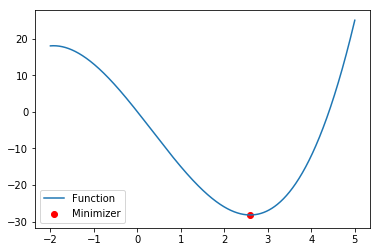

In [8]:
import matplotlib.pyplot as plt

x = np.linspace(-2,5,1000)
y = f(x)

plt.plot(x,y)
    
plt.scatter(float(sol.x[0]), sol.fun, marker='o', color='red')
plt.legend(['Function', 'Minimizer'])
plt.show()

### Unrestringierte Optimierungsprobleme

Was ist innerhalb der Funktion `minimize` eigentlich passiert? Es wurde, abhängig von der Problemstellung, ein numerisches Verfahren zur Lösung dieses Optimierungsproblems ausgewählt und auf das Problem angewendet. Die meisten numerische Verfahren für unbeschränkte Optimierungsprobleme erzeugen eine Folge

$$
x_{n+1} = x_n + s_n\,d_n,\quad n=0,1,\ldots,
$$

wobei $x_n$ die aktuelle Iterierte ist, $d_n$ eine geeignete **Suchrichtung**, welche üblicherweise eine Abstiegsrichtung ist, und $s_n$ eine **Schrittweite**. Dies wird wiederholt, bis die Iterierte $x_n$ ein bestimmtes Abbruchkriterium erfüllt, beispielsweise $|\nabla f(x_n)| \le \varepsilon$. 

Das einfachste dieser Verfahren ist das sogenannte **Gradientenverfahren**, bei dem die Suchrichtung berechnet wird durch

$$
d_n = -\nabla f(x_n).
$$

Eine geeignete Schrittweite ergibt sich durch qualifiziertes "durchtesten", beispielsweise mit "Armijo-Backtracking". Da wir den Gradienten nicht an `minimize` übergeben haben, wird dieser durch einen Finite-Differenzen-Approximation ersetzt. Der Algorithmus würde aber besser funktionieren, wenn wir den Gradienten mit angeben:

In [9]:
def Df(x):
    return 3*np.power(x, 2) - 2*x - 15

sol = optimize.minimize(f, x0, jac=Df)
sol

      fun: -28.184235498056328
 hess_inv: array([[ 0.07377658]])
      jac: array([ -1.95168971e-06])
  message: 'Optimization terminated successfully.'
     nfev: 8
      nit: 4
     njev: 8
   status: 0
  success: True
        x: array([ 2.59410985])

Im Vergleich zu unserem ersten Versuch haben wir uns hier einige Funktionsauswertungen gespart (nämlich die, die zur Berechnung der Gradientenapproximation benötigt werden).

In der Tat ist nun noch ungewiss, welcher Optimierungsalgorithmus genau angewendet wurde. In den meisten Fällen wird ein (Quasi)-Newton-Verfahren verwendet bei dem die Suchrichtung durch 

$$
d_n = -\nabla^2 f(x_n)^{-1} f(x_n)
$$

gegeben ist. Beachte, dass hier ein Gleichungssystem mit der Hessematrix $\nabla^2 f(x)$ gelöst werden muss. Sind wir in der Lage diese Hessematrix explizit zu berechnen können wir diese ebenfall der `minimize`-Funktion übergeben:

In [10]:
def DDf(x):
    return 6*x - 2

sol = optimize.minimize(f, x0, jac=Df, hess=DDf, method="Newton-CG")
sol

     fun: -28.184235498056466
     jac: array([ 0.00010172])
 message: 'Optimization terminated successfully.'
    nfev: 7
    nhev: 5
     nit: 5
    njev: 11
  status: 0
 success: True
       x: array([ 2.59410999])

Wir haben hier noch explizit angegeben, dass `minimize` das oben beschriebene Newton-Verfahren anwenden soll.

### Optimierungsprobleme mit Nebenbedingungen

Betrachten wir ein zweites Optimierungsproblem mit Zielfunktion

$$
f(x,y) = x+y\to \min!
$$

und je einer Gleichungs- und Ungleichungsnebenbedingung

$$
\begin{aligned}
g(x,y) &= x+0.5 \ge 0\\
h(x,y) &= x^2+y^2 -1 = 0.
\end{aligned}
$$

Wir definieren zunächst Zielfunktion, Gradient und die Nebenbedingungen:

In [11]:
# Zielfunktion
def f(x):
    return x[0] + x[1]

# Gradient der Zielfunktion
def Df(x):
    return np.array([1.,1.])
    
# Equality constraint
def h(x):
    return x[0]**2 + x[1]**2 - 1

# Jacobian of equality constraint
def Dh(x):
    return np.array([2*x[0], 2*x[1]])

constraints = [{'type': 'eq', 'fun': h, 'jac': Dh}]
bounds = [(-0.5,None), (None,None)]

x0 = np.array([-0.2,0.])

sol = optimize.minimize(f, x0, jac=Df, bounds=bounds, constraints=constraints)
sol

     fun: -1.3660254050073637
     jac: array([ 1.,  1.])
 message: 'Optimization terminated successfully.'
    nfev: 5
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([-0.5       , -0.86602541])

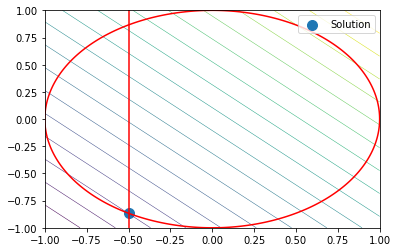

In [12]:
x = y = np.linspace(-1,1,1000)
[X,Y] = np.meshgrid(x,y)

Z = f([X,Y])
H = h([X,Y])

# Zeichne Zielfunktion
plt.contour(X,Y,Z, linewidths=.5, levels=np.linspace(np.min(Z), np.max(Z), 20))

# Zeichne Nebenbedingung h(x,y)=0
plt.contour(X,Y,H, levels=[0.], colors="red")

# Zeichne Box-beschränkung
plt.plot([-0.5, -0.5], [-1., 1.], 'r-')

# Zeichne Lösung
plt.scatter(sol.x[0], sol.x[1], marker="o", s=100, label="Solution")

plt.legend()
plt.show()